Basic Artificial Neural Networks

We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

The list of files involved:
- This notebook
- homework_modules.ipynb with all blocks implemented

In [ ]:
from time import time, sleep
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from IPython.display import clear_output
from sklearn.preprocessing import OneHotEncoder
import mnist
from __future__ import print_function
import warnings
import imgaug.augmenters as iaa

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize='x-large')
plt.rc('axes', titlesize='xx-large')
plt.rc('legend', fontsize='x-large')

warnings.filterwarnings('ignore')

# Toy example

With this example, we debug our code, start with logistic regression and then test other layers.

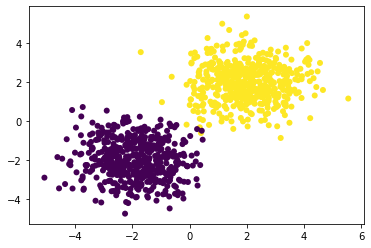

In [ ]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [ ]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 1000

In [ ]:
from tqdm import trange

# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in trange(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

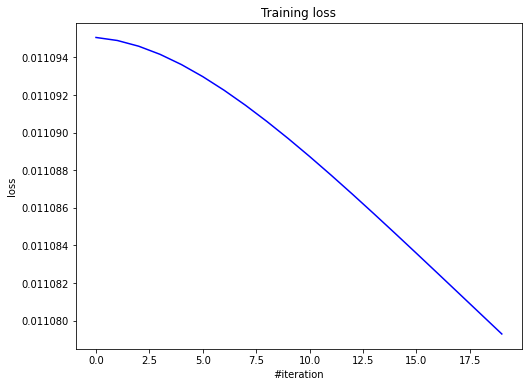

Current loss: 0.011079


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

In [ ]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

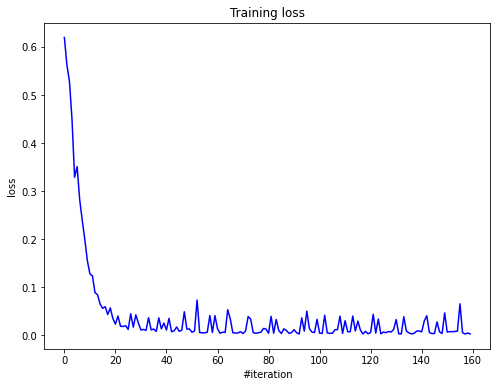

Current loss: 0.003238


In [ ]:
batch_size = 128
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old but gold [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [ ]:
import sys
import os
import time

import numpy as np


def load_dataset(flatten=False):
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return (data / np.float32(256)).squeeze()

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([-1, 28**2])
        X_val = X_val.reshape([-1, 28**2])
        X_test = X_test.reshape([-1, 28**2])


    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [ ]:
onehot = OneHotEncoder()

y_train_onehot = onehot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_onehot = onehot.fit_transform(y_val.reshape(-1, 1)).toarray()

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_train_onehot.shape)
print(y_val_onehot.shape)

(50000, 784)
(50000,)
(50000, 10)
(10000, 10)


In [ ]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_notebook(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

We train with logloss and validate on accuracy

In [ ]:
class Model:
    def __init__(self, net, net_name, criterion):
        self.net = net
        self.net_name = net_name
        self.criterion = criterion

    def __visualize(self, epoch, train_accuracy, val_accuracy):
        clear_output()

        print("Epoch", epoch)
        print("Train accuracy:", train_accuracy[-1])
        print("Val accuracy:", val_accuracy[-1])

        plt.figure(figsize=(16, 9))

        plt.title(f'Training vs validation accuracy for {self.net_name}')
        plt.xlabel("Epoch number")
        plt.ylabel("Accuracy")
        plt.plot(train_accuracy, color='blue', label='train accuracy')
        plt.plot(val_accuracy, color='orange', label='validation accuracy')
        plt.grid()
        plt.legend(loc='best')
        plt.show()

    def fit(self, X_train, X_val, y_train_onehot, y_train, y_val, optimizer, n_epoch=25, batch_size=64, optimizer_config={'learning_rate' : 0.03, 'momentum': 0.9}, optimizer_state={}, batch_iterator=iterate_minibatches):
        train_accuracy = []
        val_accuracy = []

        for epoch in range(n_epoch):
            self.net.train()
            for x_batch, y_batch in batch_iterator(X_train, y_train_onehot, batch_size, shuffle=True):
                self.net.zeroGradParameters()
                predictions = self.net.forward(x_batch)
                loss = self.criterion.forward(predictions, y_batch)
                dp = self.criterion.backward(predictions, y_batch)
                self.net.backward(x_batch, dp)
                optimizer(self.net.getParameters(), 
                            self.net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state)      
            self.net.evaluate()

            # Predict for learning curves
            predictions_train = self.net.forward(X_train).argmax(axis=-1)
            predictions_val = self.net.forward(X_val).argmax(axis=-1)
            train_accuracy.append(np.mean(predictions_train == y_train))
            val_accuracy.append(np.mean(predictions_val == y_val))
            
            # Visualize
            self.__visualize(epoch, train_accuracy, val_accuracy)

        return train_accuracy, val_accuracy

        def predict(self, input):
            self.net.evaluate()
            return self.net.forward(X_test).argmax(axis=-1)

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(ReLU())
net.add(Linear(500, 200))
net.add(ReLU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

# Model
relu = Model(net, 'relu', ClassNLLCriterion())

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9844


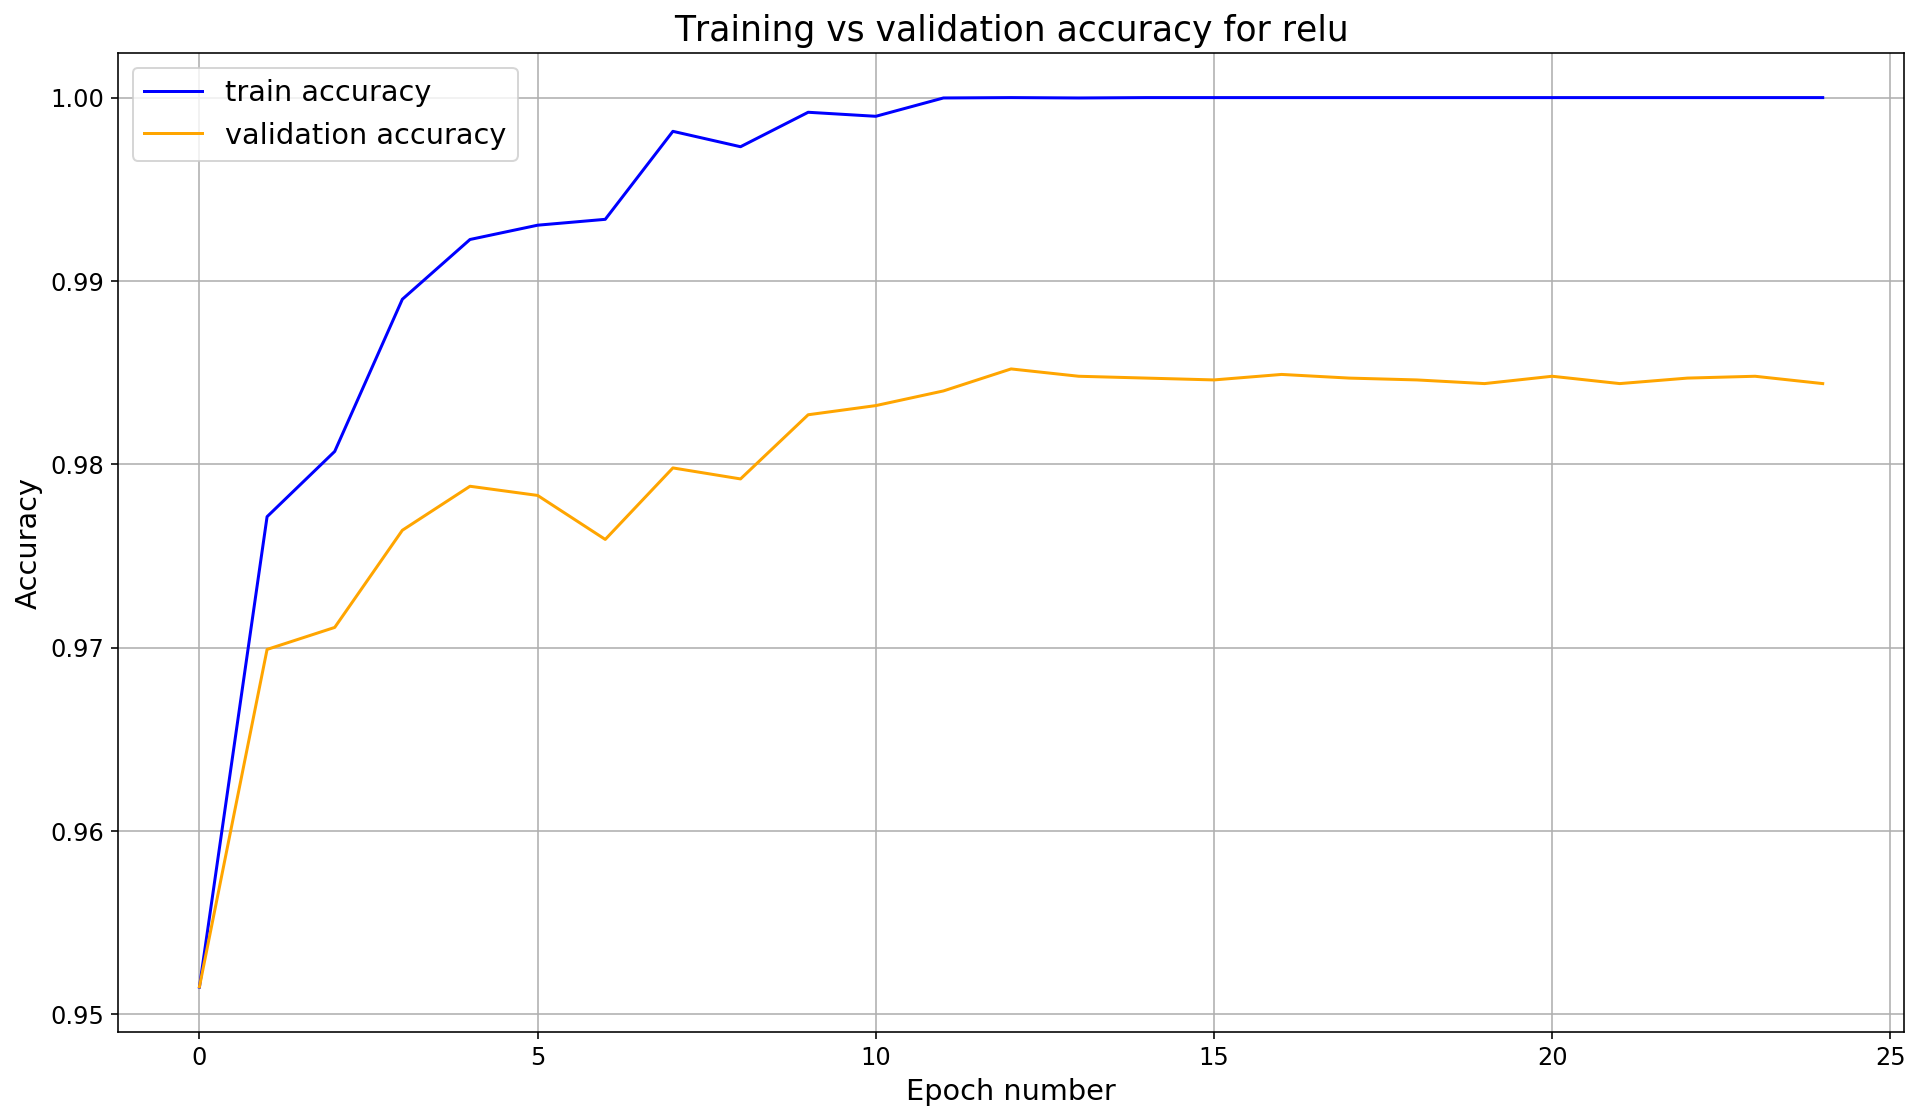

CPU times: user 9min 15s, sys: 2min 51s, total: 12min 6s
Wall time: 6min 40s


In [ ]:
%%time
data_relu = relu.fit(X_train, X_val, y_train_onehot, y_train, y_val, sgd_momentum)

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(ELU())
net.add(Linear(500, 200))
net.add(ELU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

# Model
elu = Model(net, 'elu', ClassNLLCriterion())

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.982


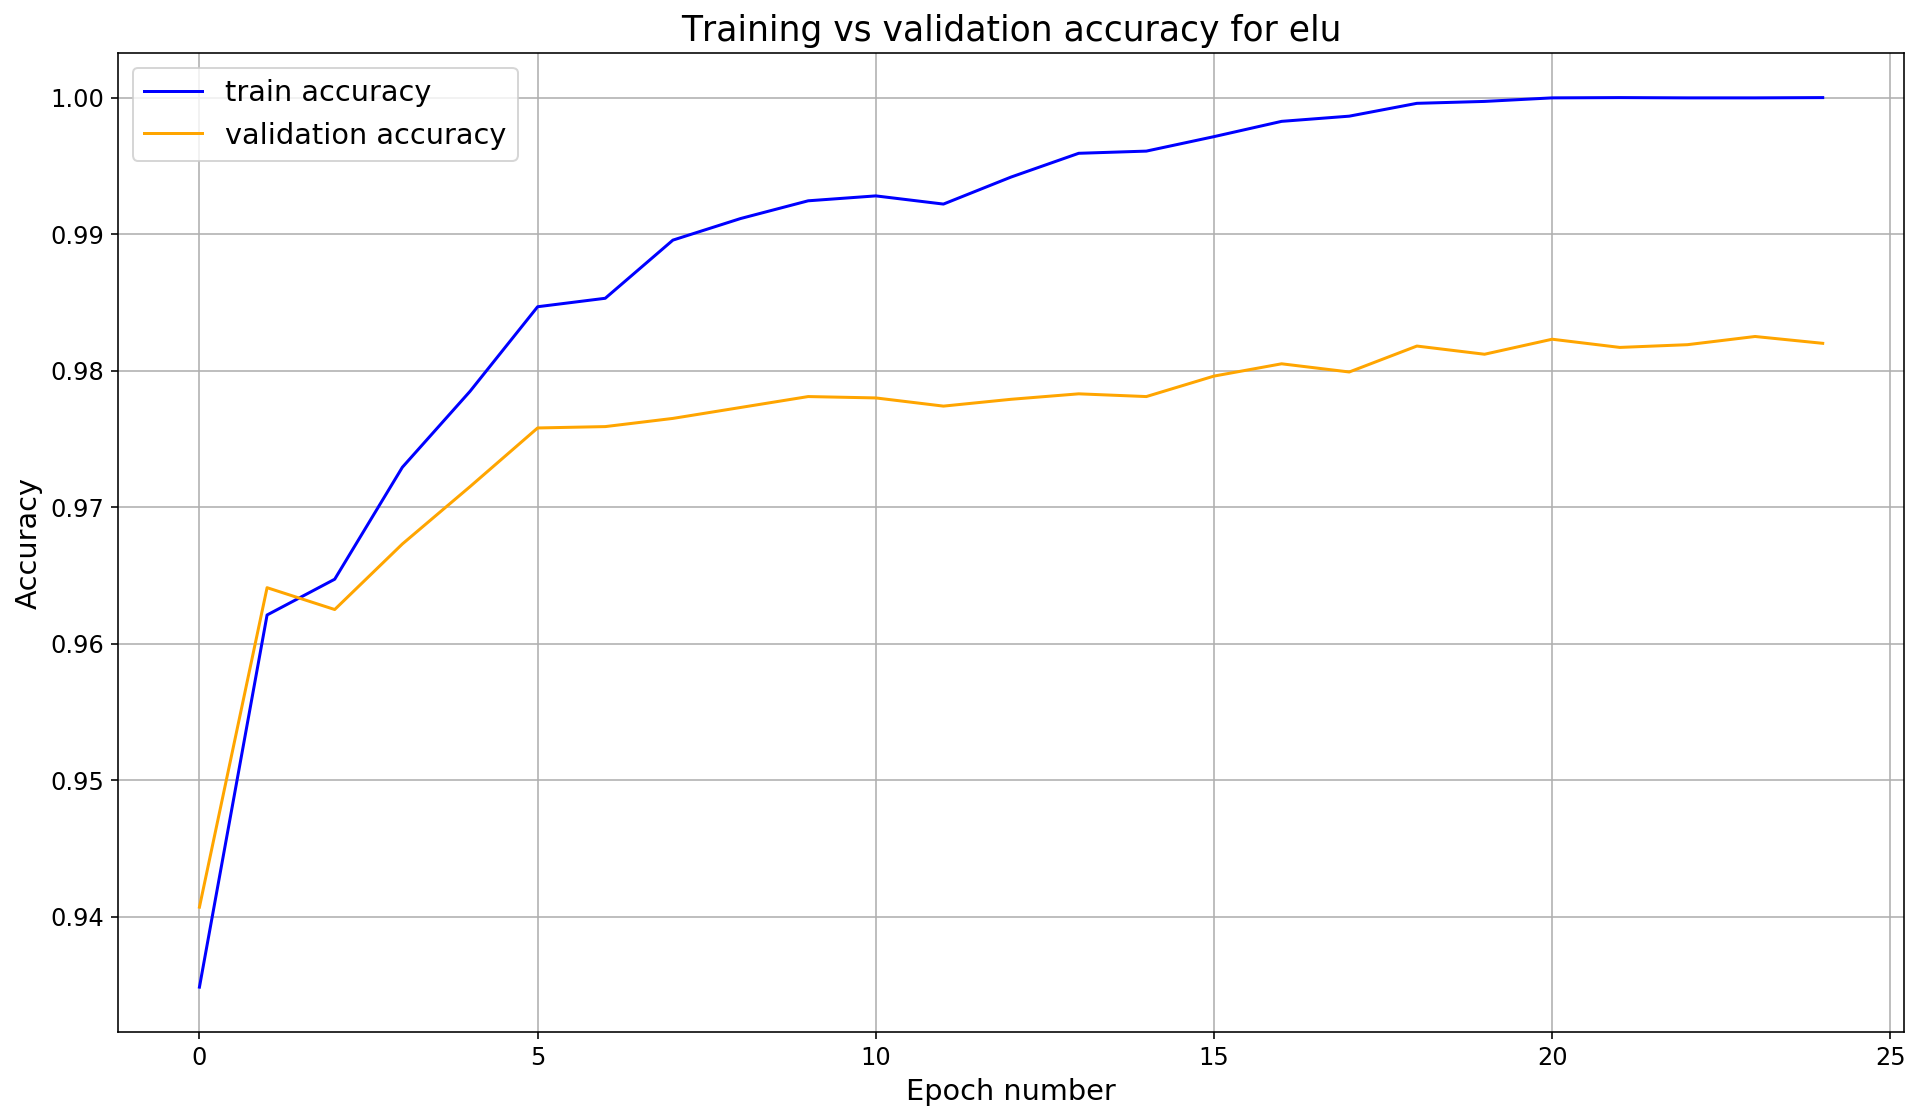

CPU times: user 10min 22s, sys: 3min 25s, total: 13min 47s
Wall time: 7min 46s


In [ ]:
%%time
data_elu = elu.fit(X_train, X_val, y_train_onehot, y_train, y_val, sgd_momentum)

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(LeakyReLU())
net.add(Linear(500, 200))
net.add(LeakyReLU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

# Model
leaky_relu = Model(net, 'leaky_relu', ClassNLLCriterion())

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9839


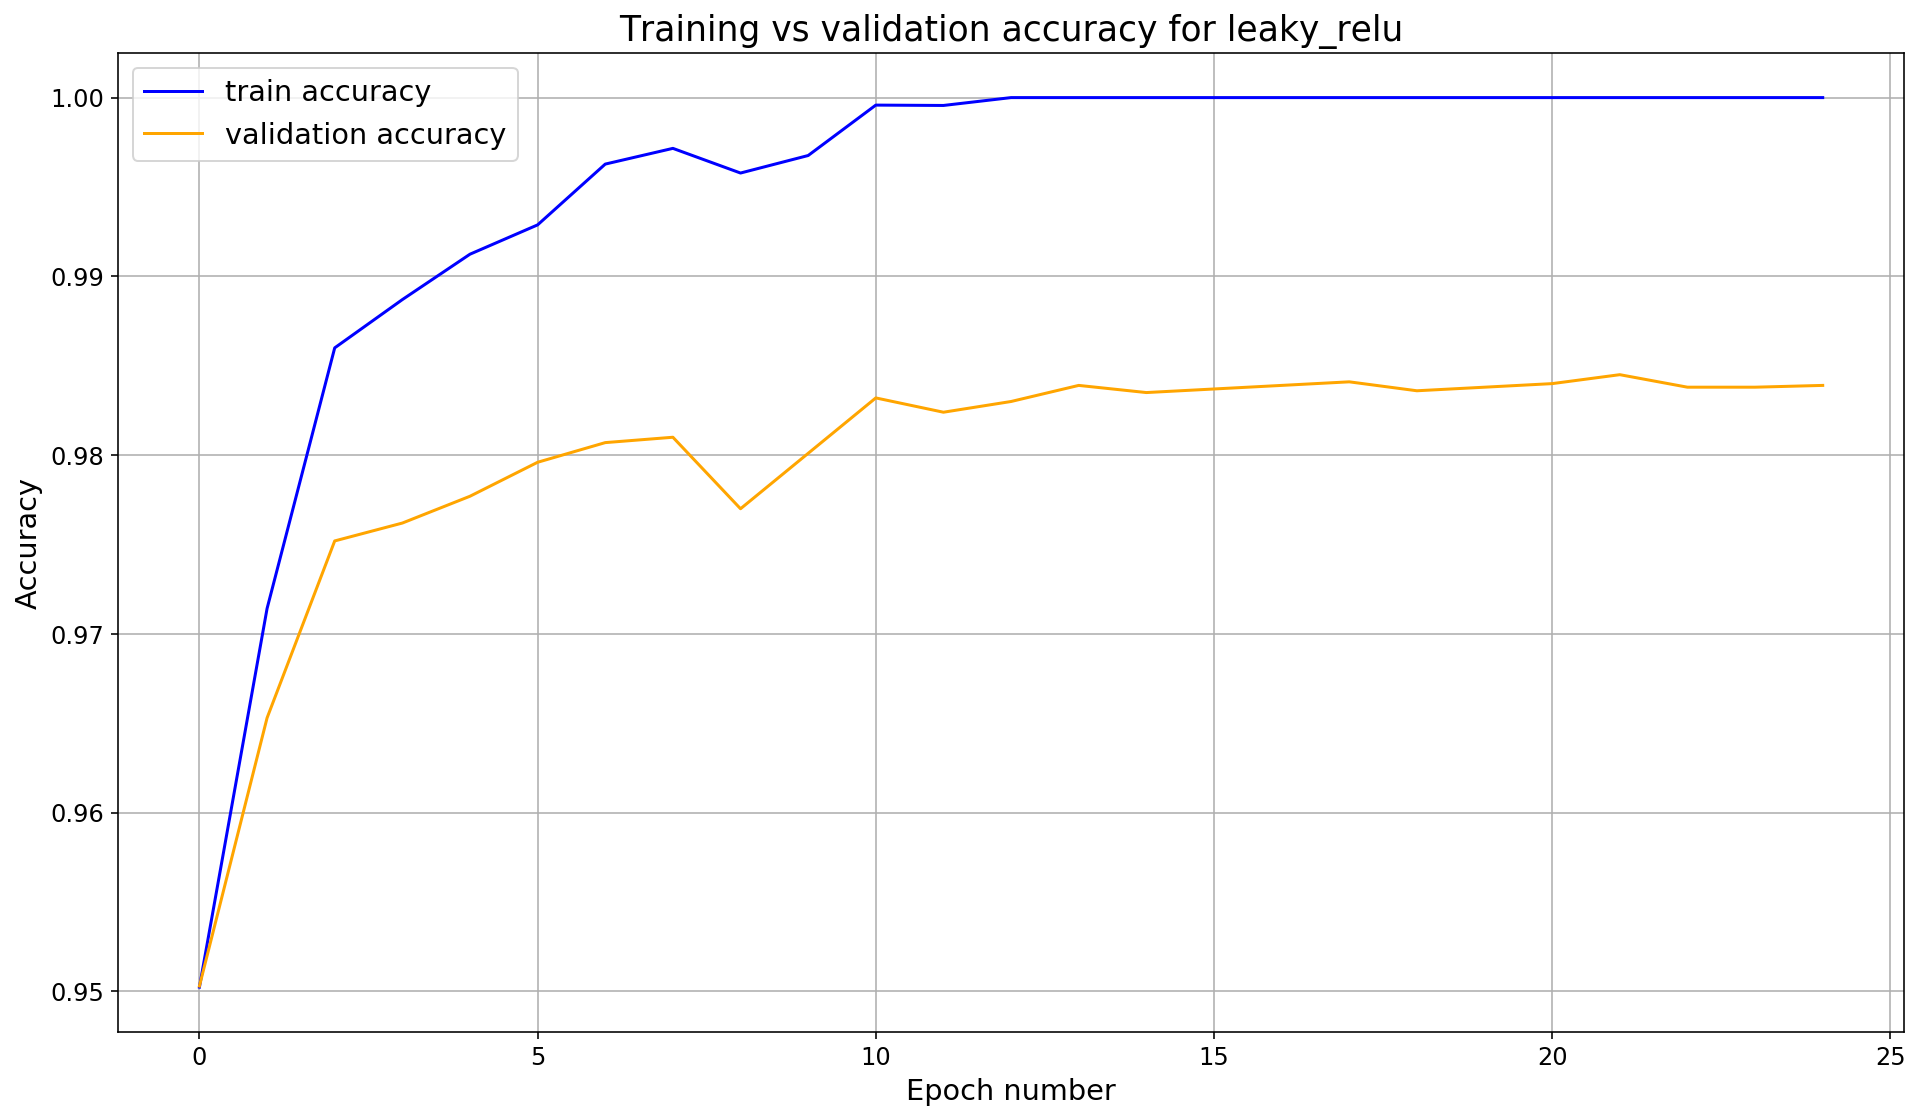

CPU times: user 9min 39s, sys: 3min 3s, total: 12min 42s
Wall time: 7min 4s


In [ ]:
%%time
data_leaky_relu = leaky_relu.fit(X_train, X_val, y_train_onehot, y_train, y_val, sgd_momentum)

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(SoftPlus())
net.add(Linear(500, 200))
net.add(SoftPlus())
net.add(Linear(200, 10))
net.add(LogSoftMax())

# Model
softplus = Model(net, 'softplus', ClassNLLCriterion())

Epoch 24
Train accuracy: 0.99728
Val accuracy: 0.9801


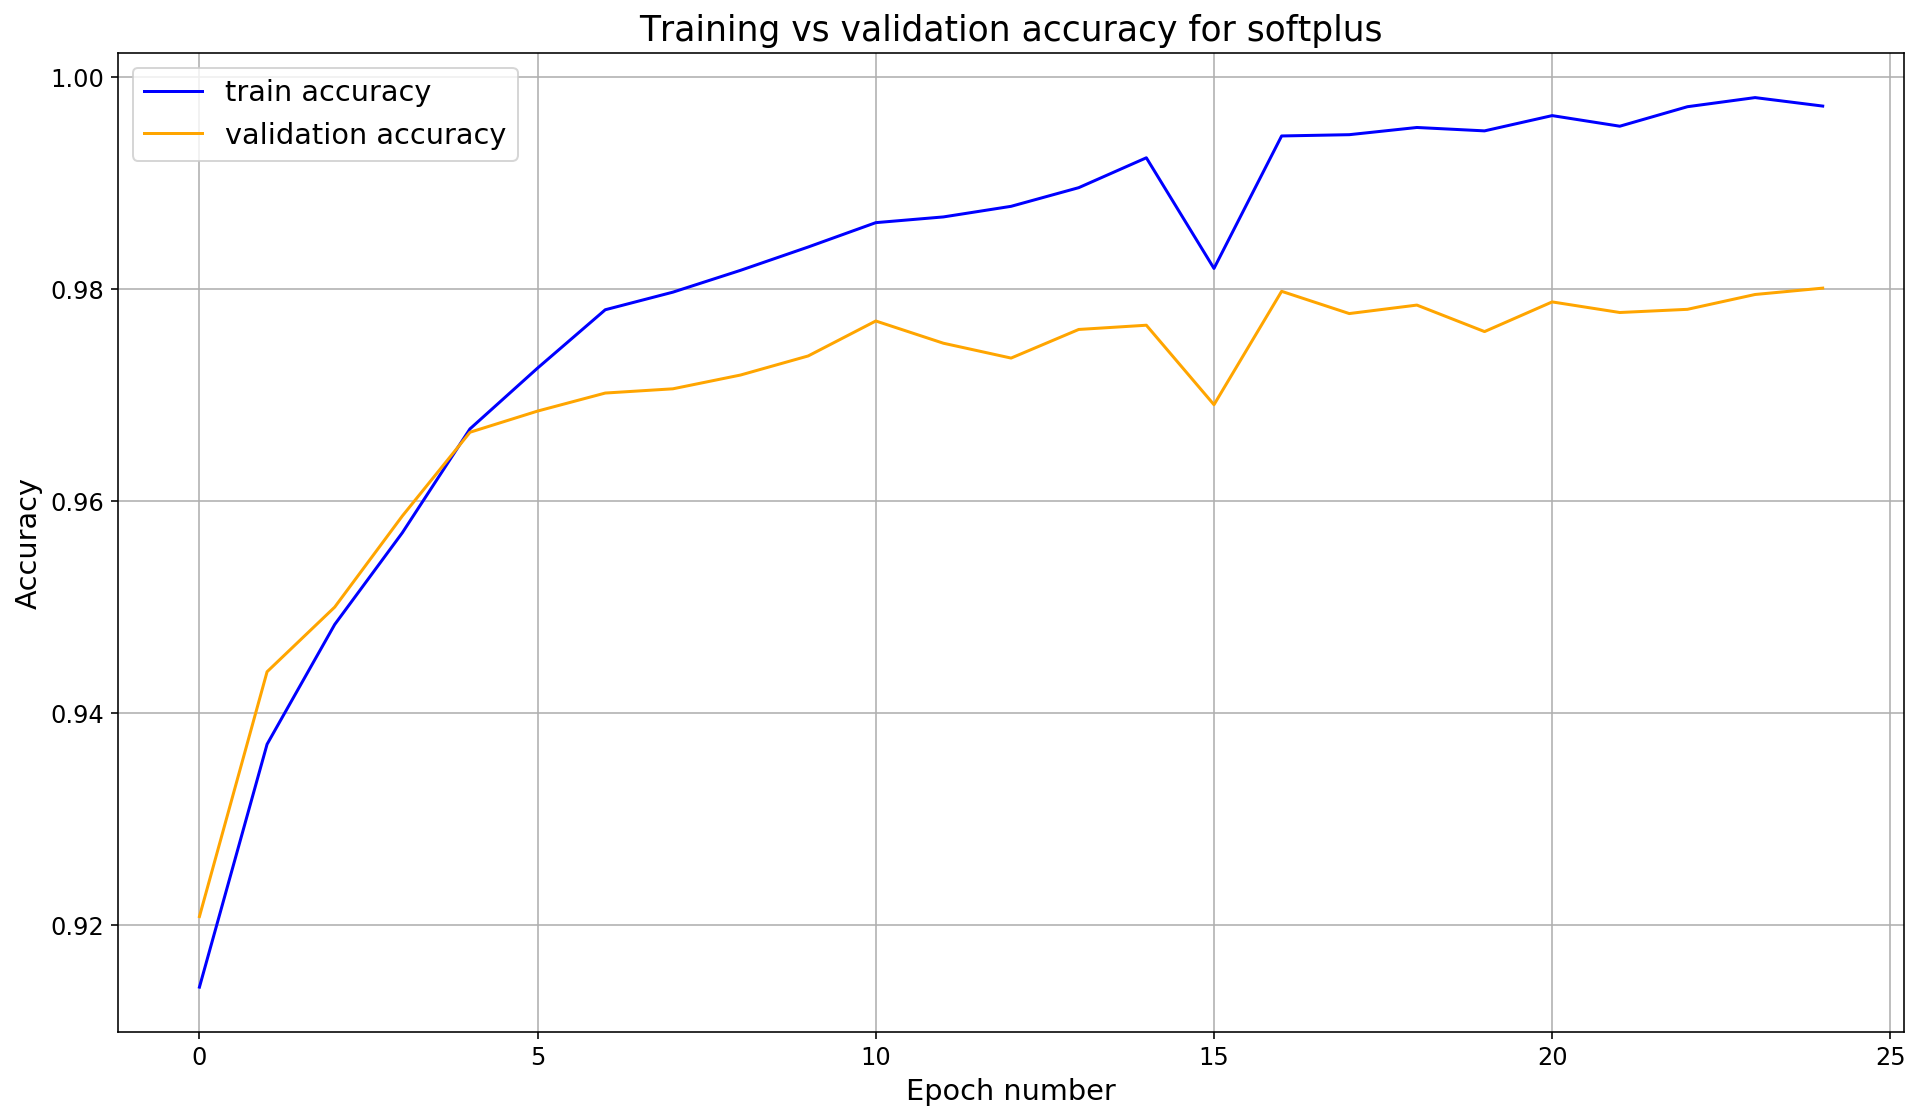

CPU times: user 11min 12s, sys: 3min 53s, total: 15min 6s
Wall time: 8min 33s


In [ ]:
%%time
data_softplus = softplus.fit(X_train, X_val, y_train_onehot, y_train, y_val, sgd_momentum)

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(500))
net.add(ReLU())
net.add(Linear(500, 200))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Linear(200, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(LogSoftMax())

# Model
relu_bn = Model(net, 'relu+batch_norm', ClassNLLCriterion())

Epoch 24
Train accuracy: 0.99838
Val accuracy: 0.9811


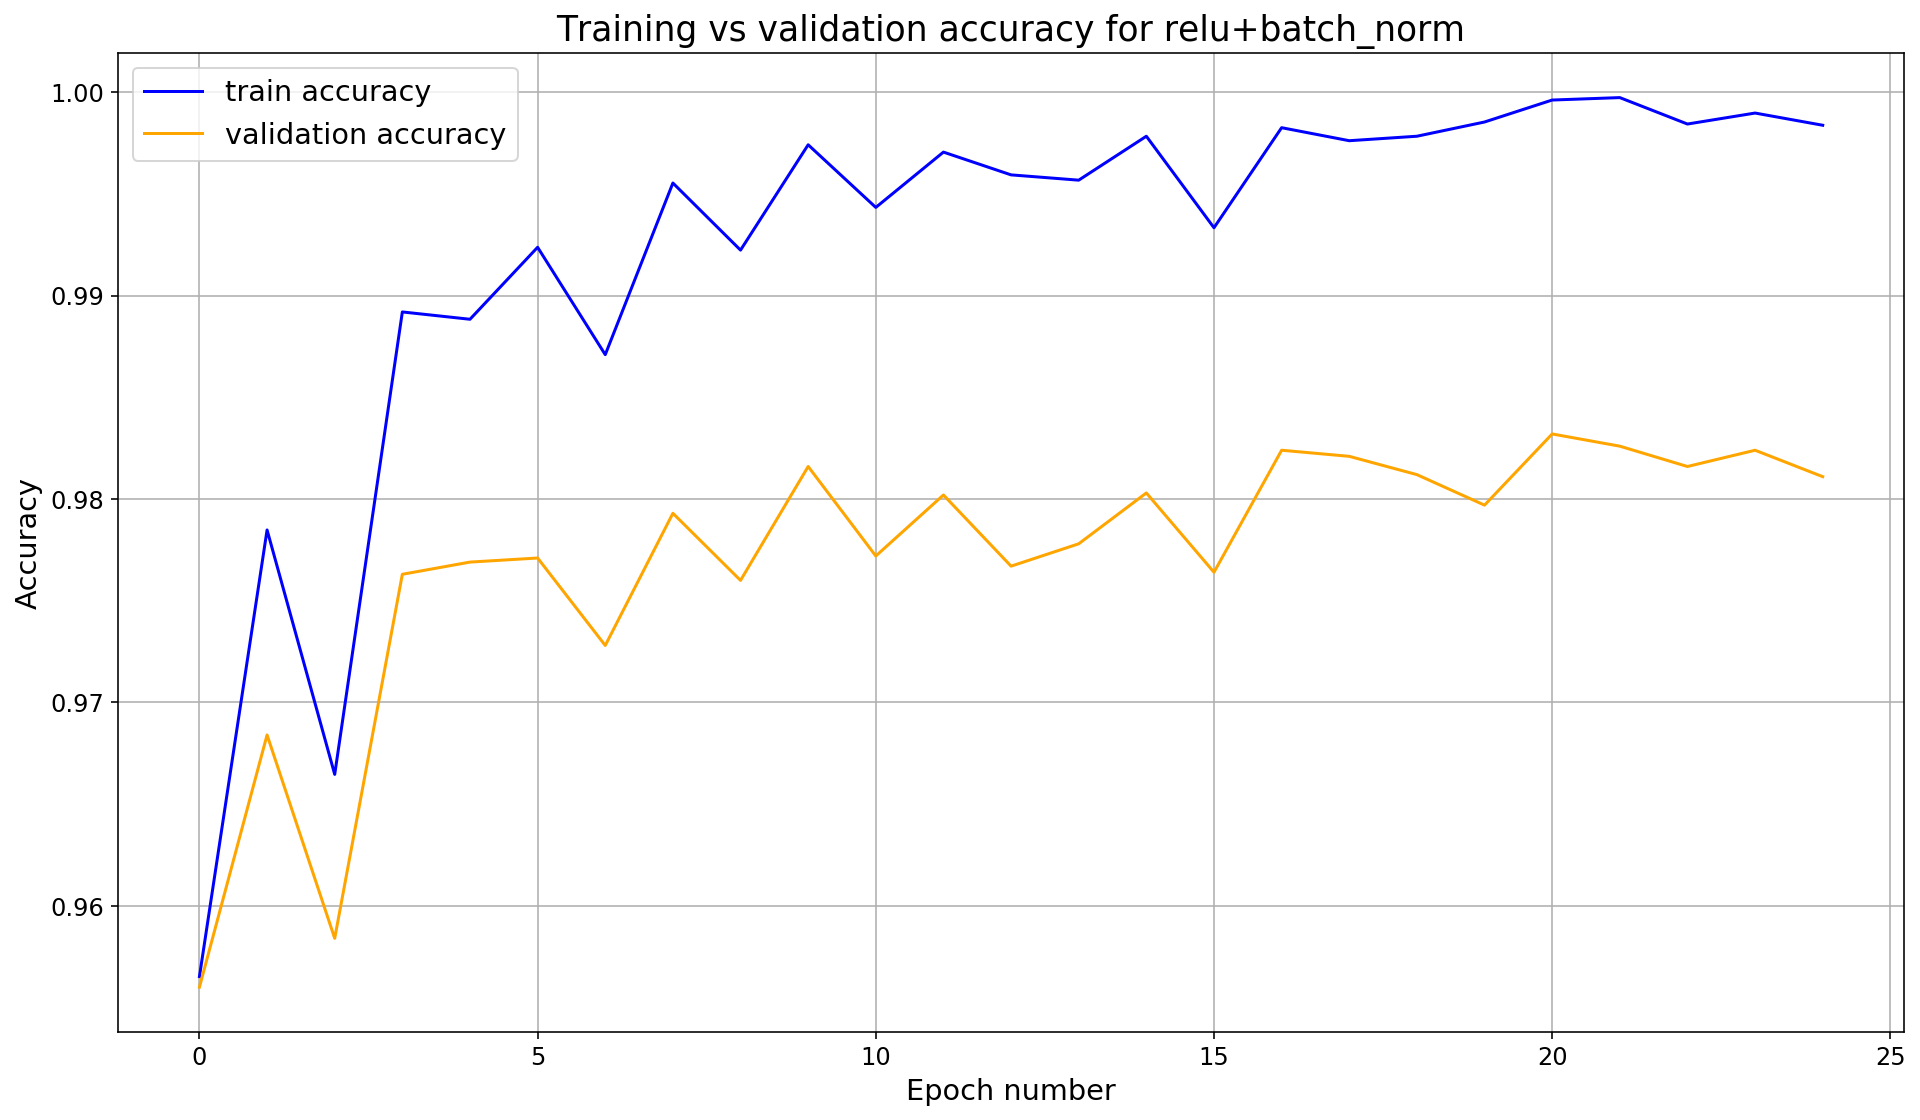

CPU times: user 11min 7s, sys: 4min 10s, total: 15min 17s
Wall time: 8min 26s


In [ ]:
%%time
data_relu_bn = relu_bn.fit(X_train, X_val, y_train_onehot, y_train, y_val, sgd_momentum, optimizer_config={'learning_rate' : 0.1, 'momentum': 0.9})

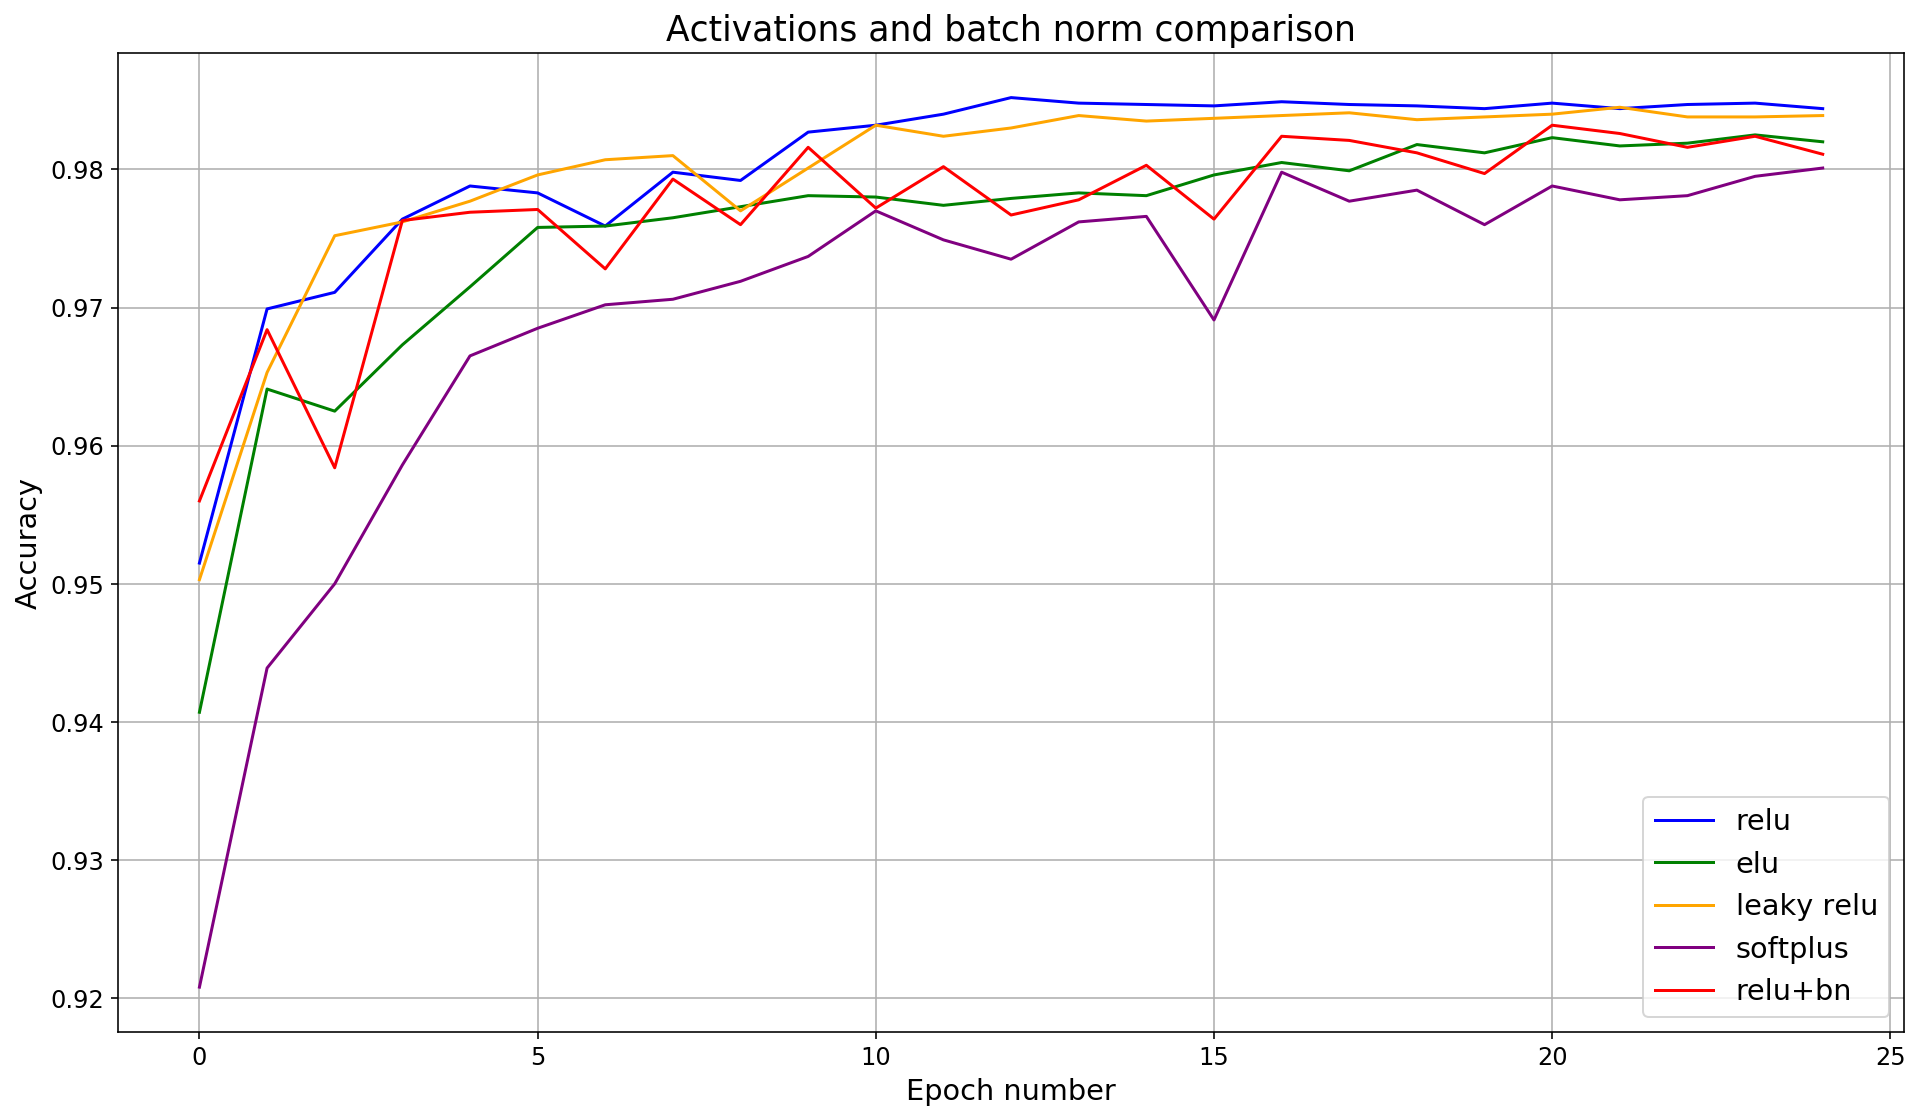

In [ ]:
# Comparison
plt.figure(figsize=(16, 9))

plt.plot(data_relu[1], color='blue', label='relu')
plt.plot(data_elu[1], color='green', label='elu')
plt.plot(data_leaky_relu[1], color='orange', label='leaky relu')
plt.plot(data_softplus[1], color='purple', label='softplus')
plt.plot(data_relu_bn[1], color='red', label='relu+bn')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('Activations and batch norm comparison')
plt.grid()
_ = plt.legend(loc='best')

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(ReLU())
net.add(Linear(500, 200))
net.add(ReLU())
net.add(Linear(200, 10))
net.add(LogSoftMax())

# Model
relu_adam = Model(net, 'relu_adam', ClassNLLCriterion())

Epoch 24
Train accuracy: 0.99798
Val accuracy: 0.9819


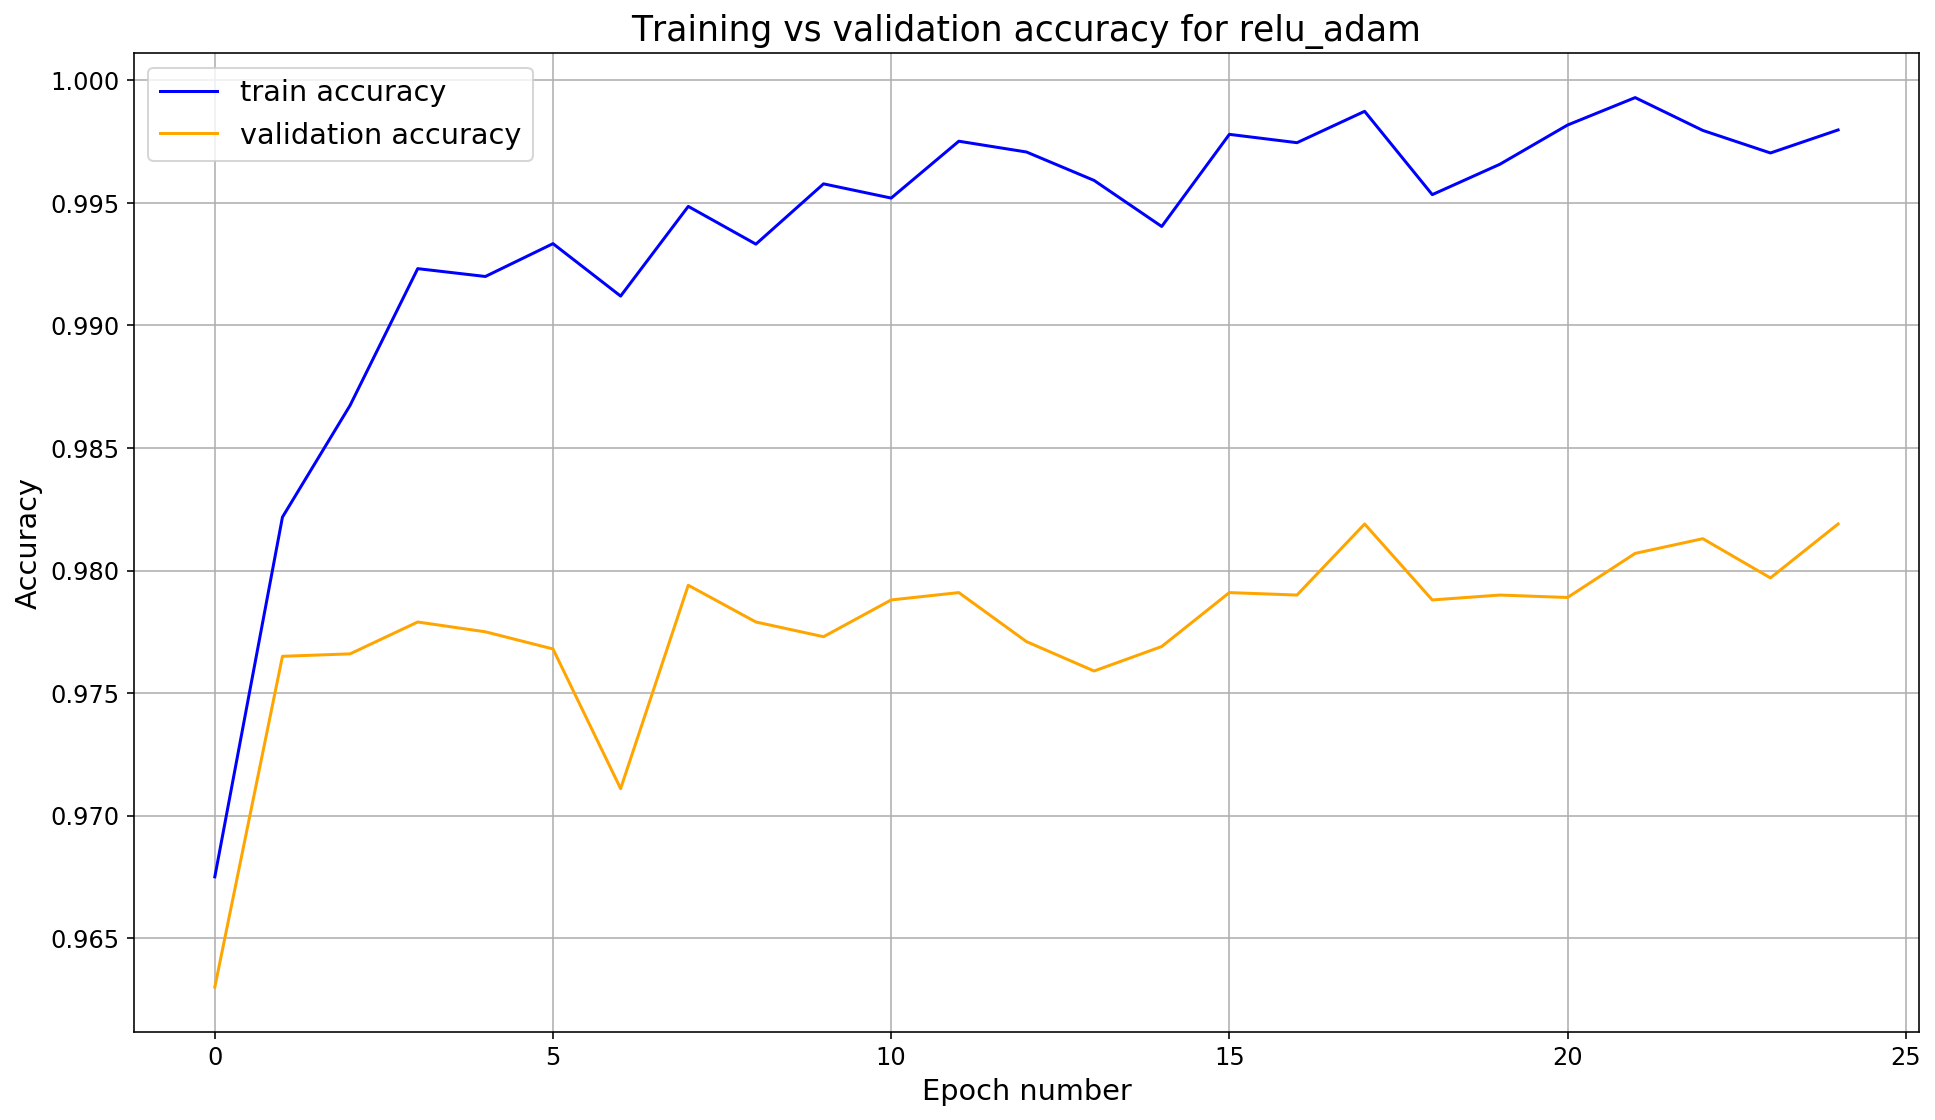

CPU times: user 13min 45s, sys: 6min 30s, total: 20min 15s
Wall time: 10min 56s


In [ ]:
%%time
data_relu_adam = relu_adam.fit(X_train, X_val, y_train_onehot, y_train, y_val, adam_optimizer, optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8})

In [ ]:
print(np.mean(relu_adam.net.forward(X_test).argmax(axis=-1) == y_test))

0.982


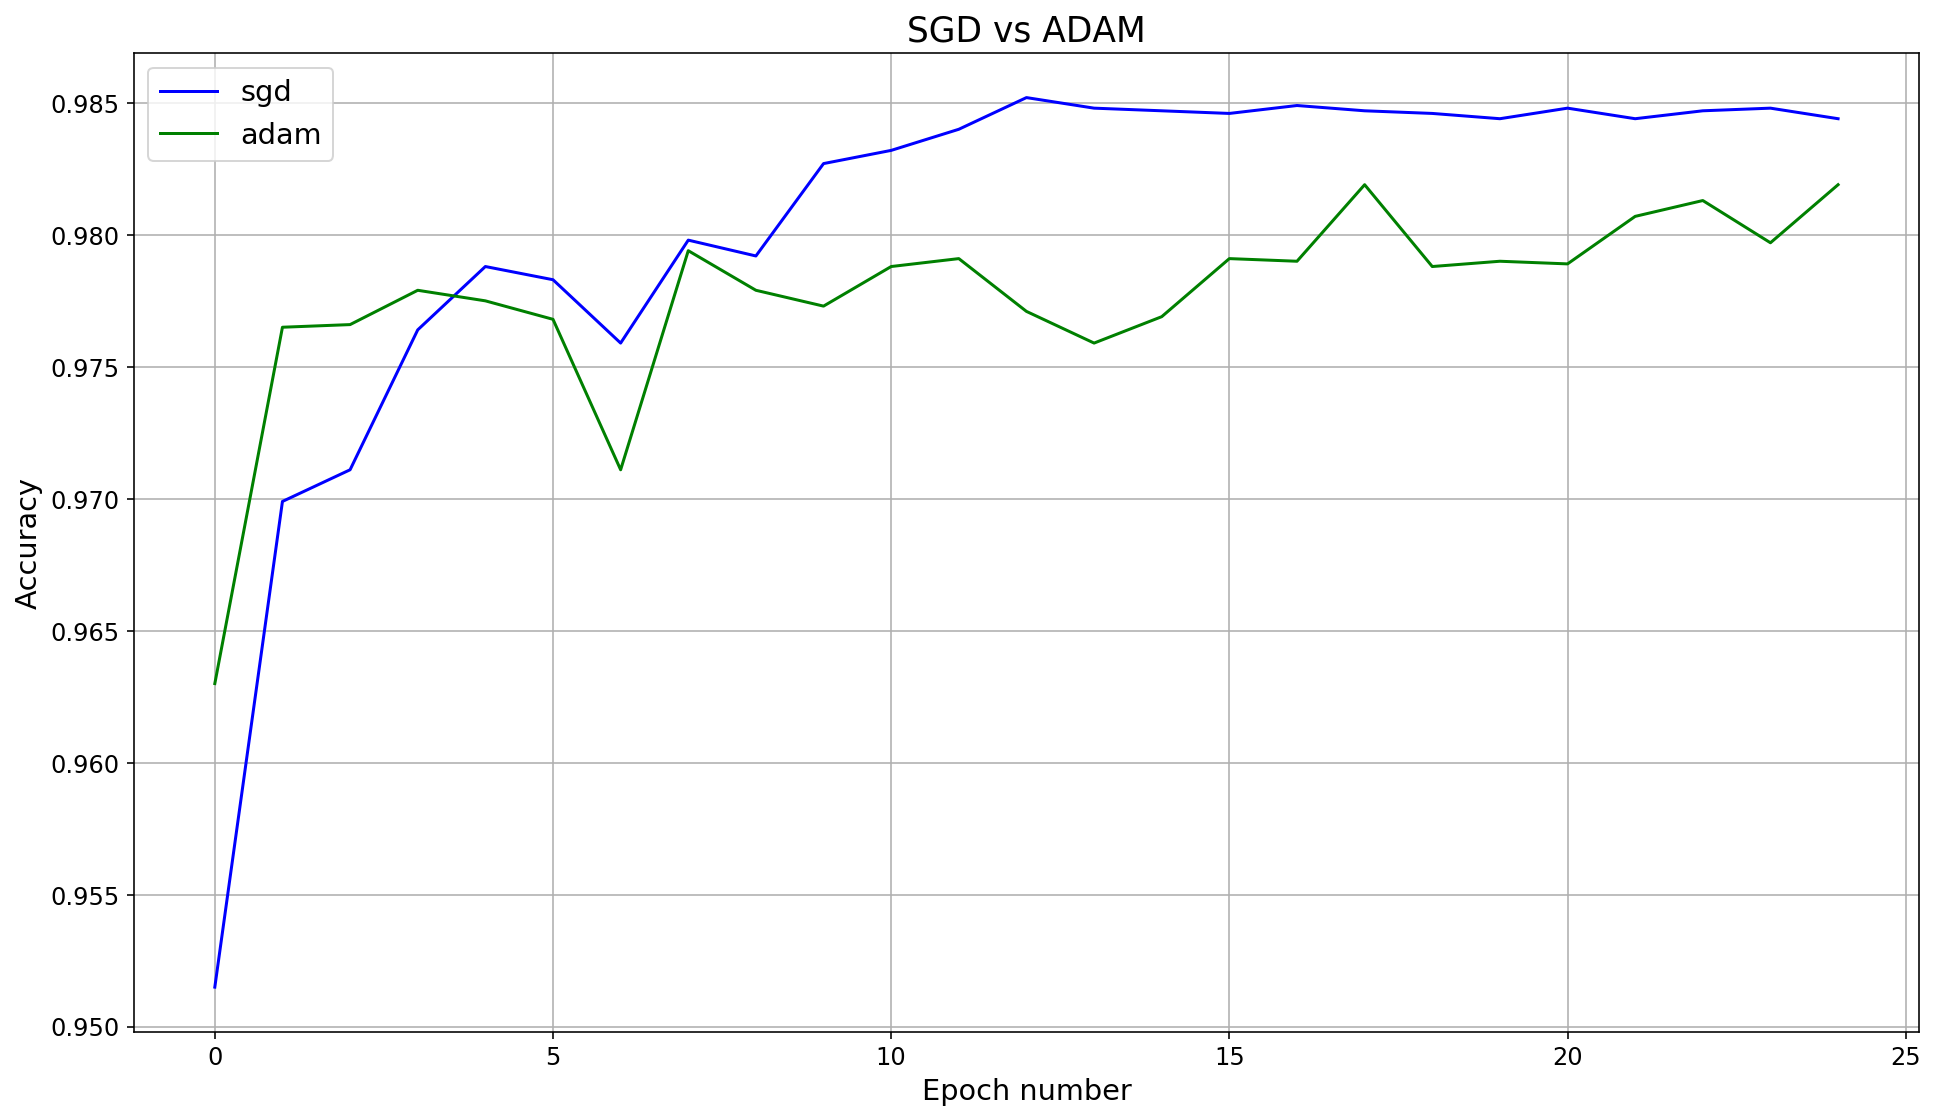

In [ ]:
# Comparison
plt.figure(figsize=(16, 9))

plt.plot(data_relu[1], color='blue', label='sgd')
plt.plot(data_relu_adam[1], color='green', label='adam')

plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.title('SGD vs ADAM')
plt.grid()
_ = plt.legend(loc='best')

**Вывод:**<br>
Видим, что при использовании ADAM наблюдается более быстрая сходимость. По этой причине он и популярен в практическом смысле. 

**Вывод:**<br>
Анализируя графики кривых обучения и общее затраченное время можем получить следующий вывод:

| Метод            	| Итоговый результат на валидации 	| Скорость сходимости 	| Затраты по времени(конкретно в этом эксперименте) 	|
|------------------	|---------------------------------	|---------------------	|---------------------------------------------------	|
| ReLU             	| 1                               	| 2                   	| 1                                                 	|
| ELU              	| 3                               	| 4                   	| 3                                                 	|
| Leaky ReLU       	| 2                               	| 3                   	| 2                                                 	|
| SoftPlus         	| 5                               	| 5                   	| 5                                                 	|
| ReLU + BatchNorm 	| 4                               	| 1                   	| 4                                                 	|

Лушим выбором при такой простейшей архитектуре оказалась активация ReLU. Хотя BatchNorm часто используется на практике(но никто не понимает почему он действительно работает и все попытки доказать что-либо заканчиваются провалом), в данной ситуации он не показал значительного прироста.

Что касается сравнения методов оптимизации, то ADAM продемонстрировал более высокую скорость сходимости относительно SGD(две эпохи против четырех), а общее время работы его эксперимента оказалось больше лишь потому, что я не реализовал критерий остановки.

**Finally**, we use all our knowledge to build a super cool model on this dataset. We use **dropout** to prevent overfitting, play with **learning rate decay**. We can use **data augmentation** such as rotations, translations to boost the score.

In [ ]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(500, 250))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(250))
net.add(ReLU())
net.add(Linear(250, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(LogSoftMax())

# Model
best = Model(net, '', ClassNLLCriterion())

In [ ]:
def iterate_aug_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm_notebook(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        
        sometimes = lambda aug: iaa.Sometimes(0.1, aug)

        seq = iaa.Sequential([
            sometimes(iaa.Crop(px=(1, 2), keep_size=True)),
            sometimes(iaa.Affine(rotate=(-5, 5)))
        ], random_order=True)

        yield seq(images=inputs[excerpt]), targets[excerpt]

Epoch 24
Train accuracy: 0.99334
Val accuracy: 0.9795


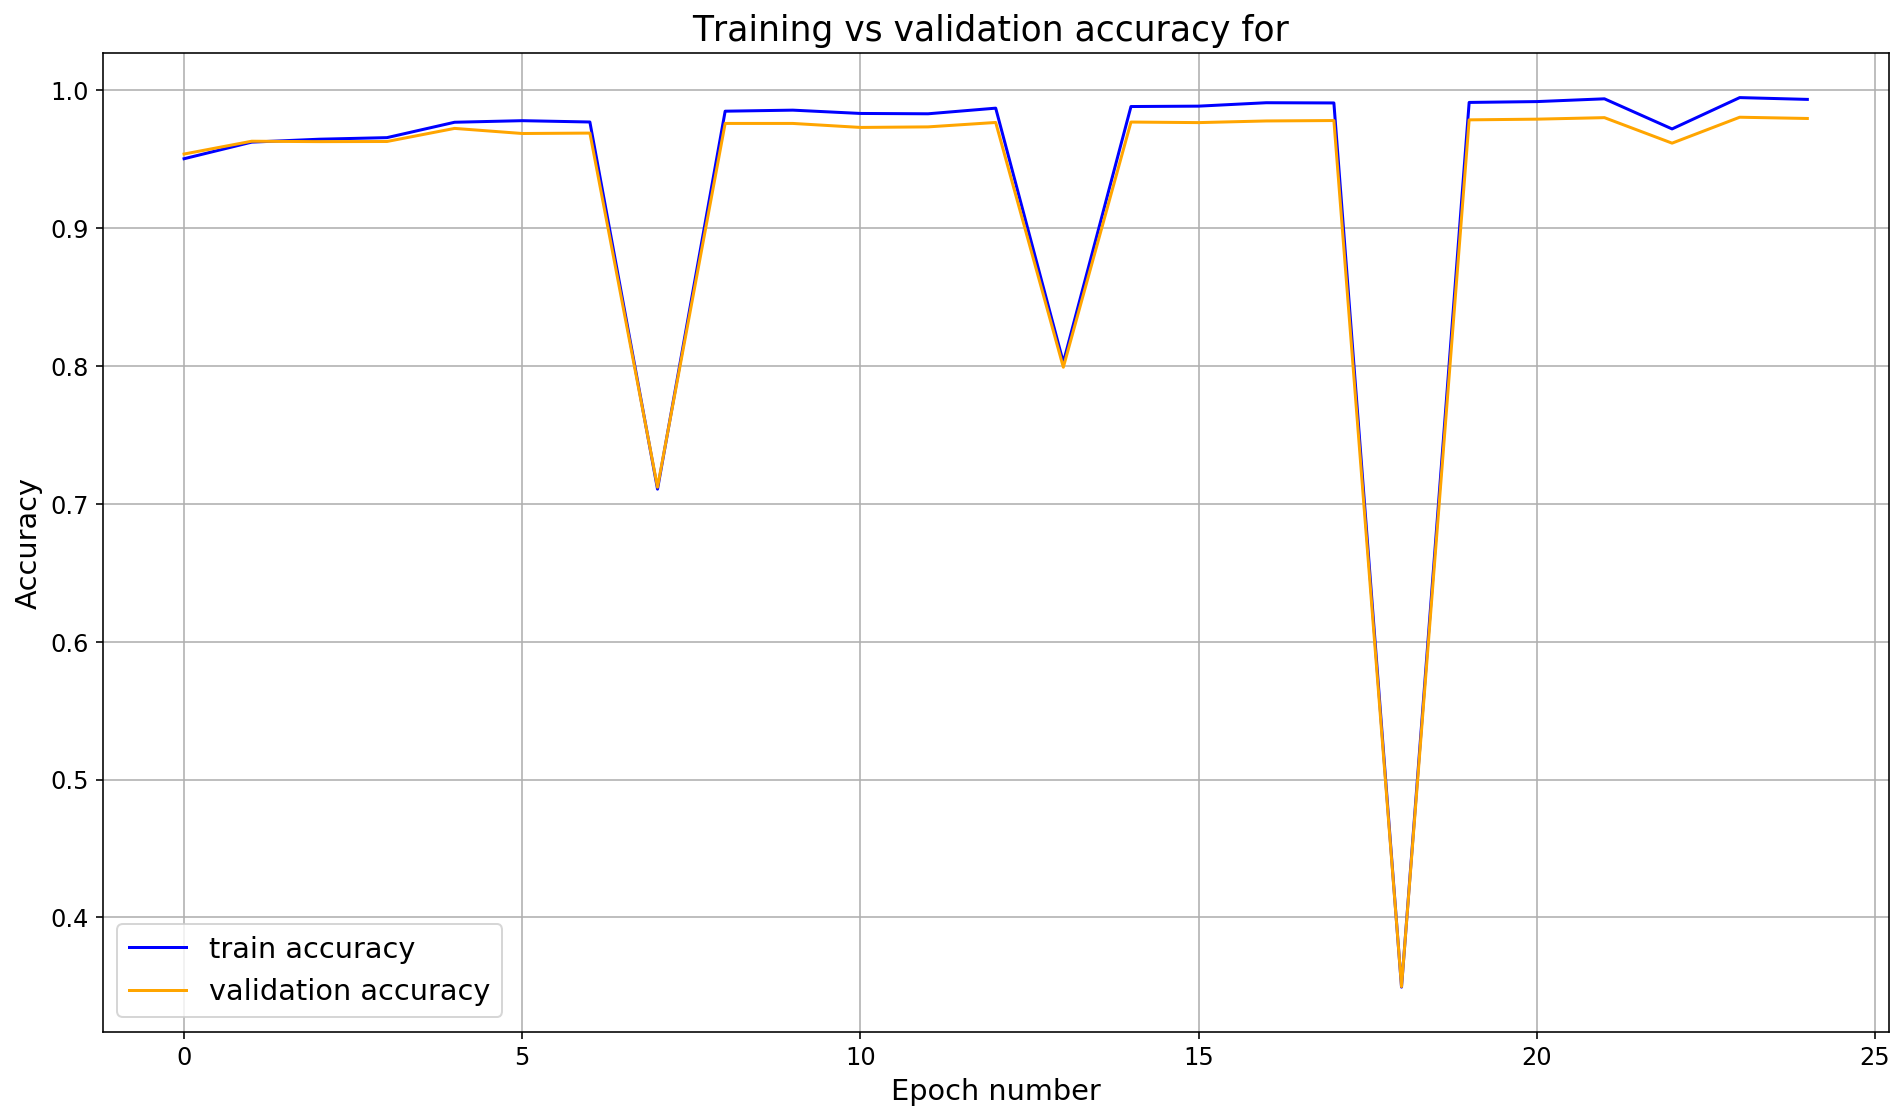

CPU times: user 22min 23s, sys: 11min 21s, total: 33min 44s
Wall time: 18min 14s


In [ ]:
%%time
best_data = best.fit(X_train, X_val, y_train_onehot, y_train, y_val, adam_optimizer, optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}, batch_iterator=iterate_aug_minibatches)

Accuracy:

In [ ]:
print(np.mean(best.net.forward(X_test).argmax(axis=-1) == y_test))

0.9825
